In [1]:
import numpy as np
import tensorflow as tf
import random as rn

In [2]:
np.random.seed(42) #for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(12345)  # for startiong core python generated random numbers in a well-defined initial state.
seed = 7
# Force TensorFlow
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.set_random_seed(1234)

In [3]:
PYTHONHASHSEED=0 

In [4]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd


import pickle

In [5]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Activation,Dropout, LSTM
from keras.models import Sequential
from keras.losses import mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model


Using TensorFlow backend.


In [6]:
# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2014-01-02'
end_date = '2019-08-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('DRT.TO', 'yahoo', start_date, end_date)

In [7]:
panel_data.head(),panel_data.shape

(            High   Low  Open  Close  Volume  Adj Close
 Date                                                  
 2014-01-02  2.60  2.50  2.55   2.55  316600       2.55
 2014-01-03  2.70  2.56  2.56   2.70  209300       2.70
 2014-01-06  2.97  2.70  2.70   2.96  280600       2.96
 2014-01-07  2.97  2.80  2.97   2.87  305700       2.87
 2014-01-08  2.94  2.80  2.94   2.85   78300       2.85, (1422, 6))

In [8]:
close = panel_data[['Close']]

In [9]:
close.head(),close.loc['2014-01-02']

(            Close
 Date             
 2014-01-02   2.55
 2014-01-03   2.70
 2014-01-06   2.96
 2014-01-07   2.87
 2014-01-08   2.85, Close    2.55
 Name: 2014-01-02 00:00:00, dtype: float64)

In [10]:
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill')

In [11]:
close.head(),close.shape,close.describe()

(            Close
 2014-01-02   2.55
 2014-01-03   2.70
 2014-01-06   2.96
 2014-01-07   2.87
 2014-01-08   2.85, (1477, 1),              Close
 count  1477.000000
 mean      5.769631
 std       1.452100
 min       2.400000
 25%       5.050000
 50%       5.950000
 75%       6.730000
 max       9.230000)

In [12]:
close_train= close[:'2019-01-01']
close_test = close['2019-01-01':]
close_train.shape,close_test.shape

((1304, 1), (174, 1))

In [13]:
close_train.head(),close_train.head(),close_train.iloc[0] ###loc for label based indexing.iloc for positional indexing

(            Close
 2014-01-02   2.55
 2014-01-03   2.70
 2014-01-06   2.96
 2014-01-07   2.87
 2014-01-08   2.85,             Close
 2014-01-02   2.55
 2014-01-03   2.70
 2014-01-06   2.96
 2014-01-07   2.87
 2014-01-08   2.85, Close    2.55
 Name: 2014-01-02 00:00:00, dtype: float64)

In [14]:
previousdays = 60

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaledclose = scaler.fit_transform(close.values)
scaledclosetrain = scaledclose[:len(close_train)]
scaledclosetest = scaledclose[len(close_train)-1:]
len(scaledclosetrain),len(scaledclosetest)

(1304, 174)

In [16]:
output = open('minmax_encoder.pkl', 'wb')
pickle.dump(scaler, output)
output.close()

In [17]:
close_train_x = []
close_train_y = []
for i in range(previousdays,len(close_train)):
    close_train_x.append(scaledclosetrain[i-previousdays:i] )
    close_train_y.append(scaledclosetrain[i] ) 
close_train_x = np.array(close_train_x)
close_train_y = np.array(close_train_y)
close_train_x.shape,close_train_y.shape

((1244, 60, 1), (1244, 1))

In [18]:
close_test_x = []
close_test_y = []
for i in range(previousdays,len(close_test)):
    close_test_x.append(scaledclosetest[i-previousdays:i])
    close_test_y.append(scaledclosetest[i]) 
close_test_x = np.array(close_test_x)
close_test_y = np.array(close_test_y)

close_test_x.shape,close_test_y.shape

((114, 60, 1), (114, 1))

In [32]:
model = Sequential()
model.add(LSTM(4, return_sequences=True, input_shape=(previousdays,1)))
model.add(LSTM(3))
model.add(Dense(1)) ### activation linear
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 4)             96        
_________________________________________________________________
lstm_4 (LSTM)                (None, 3)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss = "mean_squared_error")

In [34]:
model.fit(close_train_x,close_train_y,verbose = 1, epochs = 50)

Epoch 1/50
1244/1244 [==============================] - 5s 4ms/step - loss: 0.1970
Epoch 2/50
1244/1244 [==============================] - 4s 3ms/step - loss: 0.0622
Epoch 3/50
1244/1244 [==============================] - 4s 3ms/step - loss: 0.0192
Epoch 4/50
1244/1244 [==============================] - 4s 3ms/step - loss: 0.0148
Epoch 5/50
1244/1244 [==============================] - 4s 4ms/step - loss: 0.0103
Epoch 6/50
1244/1244 [==============================] - 4s 4ms/step - loss: 0.0064
Epoch 7/50
1244/1244 [==============================] - 4s 3ms/step - loss: 0.0044
Epoch 8/50
1244/1244 [==============================] - 4s 4ms/step - loss: 0.0038
Epoch 9/50
1244/1244 [==============================] - 4s 3ms/step - loss: 0.0037
Epoch 10/50
1244/1244 [==============================] - 4s 4ms/step - loss: 0.0035
Epoch 11/50
1244/1244 [==============================] - 5s 4ms/step - loss: 0.0034
Epoch 12/50
1244/1244 [==============================] - 5s 4ms/step - loss: 0.0033
E

In [35]:
model.save('stockprice.hdf5')

In [36]:
#model = load_model('stockprice.hdf5')

In [37]:
pkl_file = open('minmax_encoder.pkl', 'rb')
scaler = pickle.load(pkl_file) 
pkl_file.close()

In [38]:
### Test data predictionn..
ypredtest = model.predict(close_test_x)
ypredtest = ypredtest.tolist()
ypredtest = scaler.inverse_transform(ypredtest)
ypredtest = np.array( [elt[0] for elt in ypredtest] )

close_test_pred = close_test[previousdays:]
assert len(close_test_pred) == len(ypredtest)
close_test_pred['predtest'] = ypredtest 
close_test_pred.head(),len(close_test_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(            Close  predtest
 2019-03-26   8.45  7.294002
 2019-03-27   8.71  7.397194
 2019-03-28   8.53  7.526725
 2019-03-29   8.50  7.650834
 2019-04-01   8.49  7.763891, 114)

In [39]:
ypredtest,close_test_pred['Close'].values

(array([7.29400195, 7.39719358, 7.52672456, 7.65083379, 7.76389107,
        7.8642216 , 7.95761353, 8.03800025, 8.11522462, 8.20096795,
        8.29397069, 8.3813009 , 8.45029209, 8.50992975, 8.56707759,
        8.61398769, 8.65110297, 8.68450305, 8.71838189, 8.749845  ,
        8.77611758, 8.80276633, 8.83237713, 8.85969678, 8.88002571,
        8.90013643, 8.92231278, 8.93919276, 8.94179413, 8.93647741,
        8.92600843, 8.90404133, 8.88063229, 8.83297231, 8.77452582,
        8.69792839, 8.60661756, 8.50646859, 8.40445836, 8.30946898,
        8.22107054, 8.1283202 , 8.0401074 , 7.95156566, 7.86592898,
        7.78576861, 7.70749799, 7.63810215, 7.59394323, 7.5552997 ,
        7.52923067, 7.51811847, 7.50793772, 7.49671236, 7.49356141,
        7.5011416 , 7.5181315 , 7.53724076, 7.58214711, 7.6349056 ,
        7.68777646, 7.73788229, 7.78042746, 7.79892688, 7.79927862,
        7.78133204, 7.74631821, 7.69760628, 7.64607723, 7.59765517,
        7.55273335, 7.53920949, 7.53461985, 7.53

In [40]:
rms=np.sqrt(np.mean(np.power((close_test_pred['Close'].values  - ypredtest),2)))
rms

0.42159703160309

In [41]:
### Train data predictionn..
ypredtrain = model.predict(close_train_x)
ypredtrain = ypredtrain.tolist()
ypredtrain = scaler.inverse_transform(ypredtrain)
ypredtrain= np.array( [elt[0] for elt in ypredtrain] )

close_train_pred = close_train[previousdays:]
assert len(close_train_pred) == len(ypredtrain)
close_train_pred['predtrain'] = ypredtrain
close_train_pred.head(),len(close_train_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(            Close  predtrain
 2014-03-27   3.15   3.178657
 2014-03-28   3.14   3.182911
 2014-03-31   3.13   3.189172
 2014-04-01   3.20   3.195866
 2014-04-02   3.10   3.205328, 1244)

In [42]:
ypredtrain, close_train_pred['Close'].values

(array([3.17865744, 3.18291076, 3.1891717 , ..., 5.86184722, 5.82011625,
        5.81105156]),
 array([3.1500001 , 3.1400001 , 3.13000011, ..., 5.82000017, 6.11000013,
        6.11000013]))

In [43]:
rms=np.sqrt(np.mean(np.power((close_train_pred['Close'].values - ypredtrain),2)))
rms

0.28287778048695394

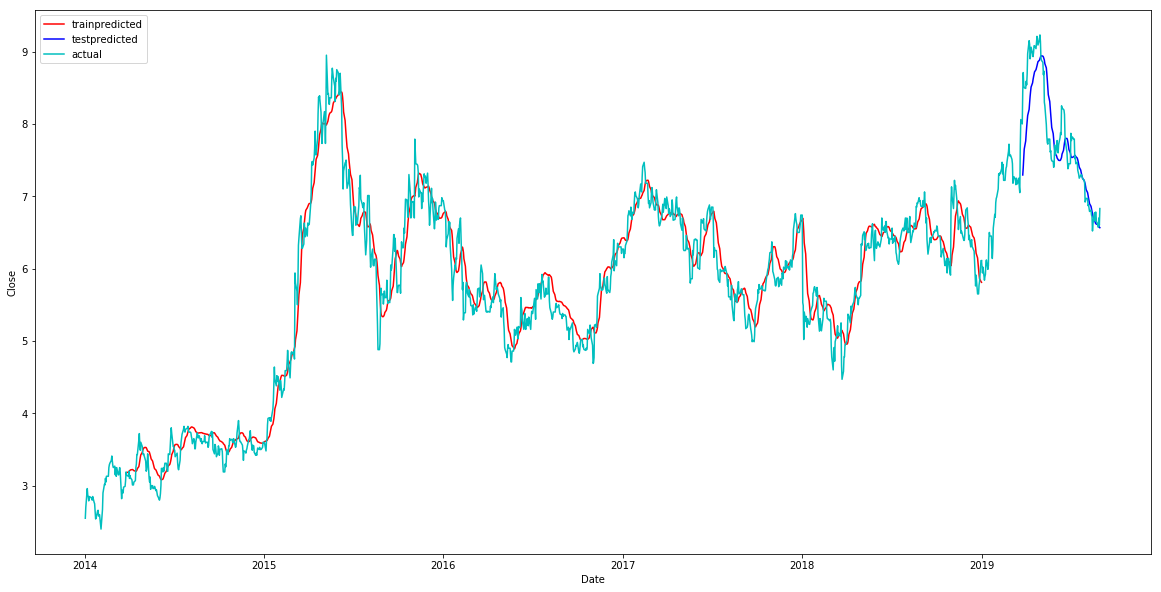

In [44]:
plt.figure(figsize=(20,10))
plt.plot(close_train_pred[['predtrain']],c='r',label='trainpredicted')
plt.plot(close_test_pred[['predtest']],c ='b',label ='testpredicted')
plt.plot(close_train ,c = 'c',label = 'actual')
plt.plot(close_test ,c ='c')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(loc='upper left')
plt.savefig('stockprediction.png')